In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import regex as re
from collections import defaultdict


In [218]:
df = pd.read_csv('../other/frac_merge_peak.csv')


In [219]:
df['XEC_FIELD_Code'] = pd.Categorical(df['XEC_FIELD']).codes
df['Reservoir_Code'] = pd.Categorical(df['Reservoir']).codes


In [220]:
df.columns


Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak', u'XEC_FIELD_Code', u'Reservoir_Code'],
      dtype='object')

In [227]:
df.groupby(['XEC_FIELD', 'XEC_FIELD_Code'])['XEC_FIELD'].count()


XEC_FIELD        XEC_FIELD_Code
COTTONWOOD DRAW  0                 14
DIXIELAND        1                 47
FORD, WEST       2                 91
GRISHAM          3                  9
PHANTOM          4                  7
RED HILLS        5                  1
STATELINE        6                  3
TWO GEORGES      7                  6
Name: XEC_FIELD, dtype: int64

In [228]:
df.groupby(['Reservoir', 'Reservoir_Code'])['Reservoir'].count()


Reservoir         Reservoir_Code
Wolfcamp Shale A  0                 89
Wolfcamp Shale C  1                 14
Wolfcamp Shale D  2                 75
Name: Reservoir, dtype: int64

In [229]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster', u'XEC_FIELD_Code', u'Reservoir_Code']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape


(133, 21)

In [230]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))


In [231]:
X_OLS_train = sm.add_constant(standardize_2sd(X_train.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1)))
model = sm.OLS(y_train, X_OLS_train)
model = model.fit()
print model.summary()


                            OLS Regression Results                            
Dep. Variable:               OIL_Peak   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     6.851
Date:                Mon, 07 Nov 2016   Prob (F-statistic):           1.14e-11
Time:                        13:24:08   Log-Likelihood:                -881.57
No. Observations:                 133   AIC:                             1803.
Df Residuals:                     113   BIC:                             1861.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               615.9413     17.21

In [232]:
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_OLS_train.drop('const', axis=1), y_train)
print 'Train R2: {0}'.format(model.score(X_OLS_train.drop('const', axis=1), y_train))
X_OLS_test = standardize_2sd_test(X_test.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1), 
                                        X_train.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1))
print 'Test R2: {0}'.format(model.score(X_OLS_test, y_test))


Train R2: 0.53531511995
Test R2: 0.186603706936


In [233]:
lasso = sm.OLS(y_train, X_OLS_train).fit_regularized(alpha=1, L1_wt=1)
lasso.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               OIL_Peak   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5.827
Date:                Mon, 07 Nov 2016   Prob (F-statistic):           6.67e-10
Time:                        13:24:37   Log-Likelihood:                -887.11
No. Observations:                 133   AIC:                             1814.
Df Residuals:                     113   BIC:                             1872.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               614.9413     17.946     34.266      0.000       579.386   650.496
Clusters/Stage     -290.3043    128.528     -2.259      0.026      -544.942   -35.666
Perfs/Cluster      -394.7479    219.138     -1.801      0.074      -828.900    39.404
#_of_Stages         154.1554     72.917      2.114      0.037         9.695   298.616
ISIP/Ft            -209.6567     72.143     -2.906      0.004      -352.585   -66.729
Rate/Ft              68.6648     83.433      0.823      0.412       -96.631   233.960
Rate/Perf          -139.6013    157.880     -0.884      0.378      -452.389   173.187
Avg_Prop_Conc       -21.0598     64.863     -0.325      0.746      -149.565   107.446
Max_Prop_Conc       -38.8937     42.717     -0.910      0.365      -123.524    45.737
Rate/Cluster       -139.9728    140.368     -0.997      0.321      -418.067   138.122
Max_Rate            154.5035     91.257      1.693      0.093       -26.293   335.300
Cluster_Spacing            0          0        nan        nan             0         0
Avg_Pressure        222.7534     73.748      3.020      0.003        76.646   368.861
Prop_Lbs/Ft                0          0        nan        nan             0         0
Prop_Lbs/Perf              0          0        nan        nan             0         0
Max_Pressure        -71.3550     52.018     -1.372      0.173      -174.412    31.702
Fluid_Gal/Perf     -157.3745    122.685     -1.283      0.202      -400.435    85.686
Fluid_Gal/Ft               0          0        nan        nan             0         0
Prop_Lbs/Cluster           0          0        nan        nan             0         0
Fluid_Gal/Cluster          0          0        nan        nan             0         0
==============================================================================
Omnibus:                       30.746   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.093
Skew:                           0.980   Prob(JB):                     1.99e-14
Kurtosis:                       5.747   Cond. No.                         89.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
X_lasso_train = X_train[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_train_std = standardize_2sd(X_lasso_train)
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_lasso_train_std, y_train)
print 'Train R2: {0}'.format(model.score(X_lasso_train_std, y_train))
X_lasso_test = X_test[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_test_std = standardize_2sd_test(X_lasso_test, X_lasso_train)
print 'Test R2: {0}'.format(model.score(X_lasso_test_std, y_test))


Train R2: 0.506618464039
Test R2: 0.188315827225


In [487]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='field', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)
    

In [489]:
run_pooled = True

In [485]:
data = dict(x=X_lasso_train_std, y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    if run_pooled:
        trc_pooled = pm.backends.text.load('../other/traces_txt/trc_pooled')
    else:
        step = pm.NUTS()
        start = pm.find_MAP()
        trace = pm.backends.Text('../other/traces_txt/trc_pooled')
        trc_pooled = pm.sample(2000, njobs=1, step=step, start=start, trace=trace)    
    

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:16<00:00, 118.59it/s]


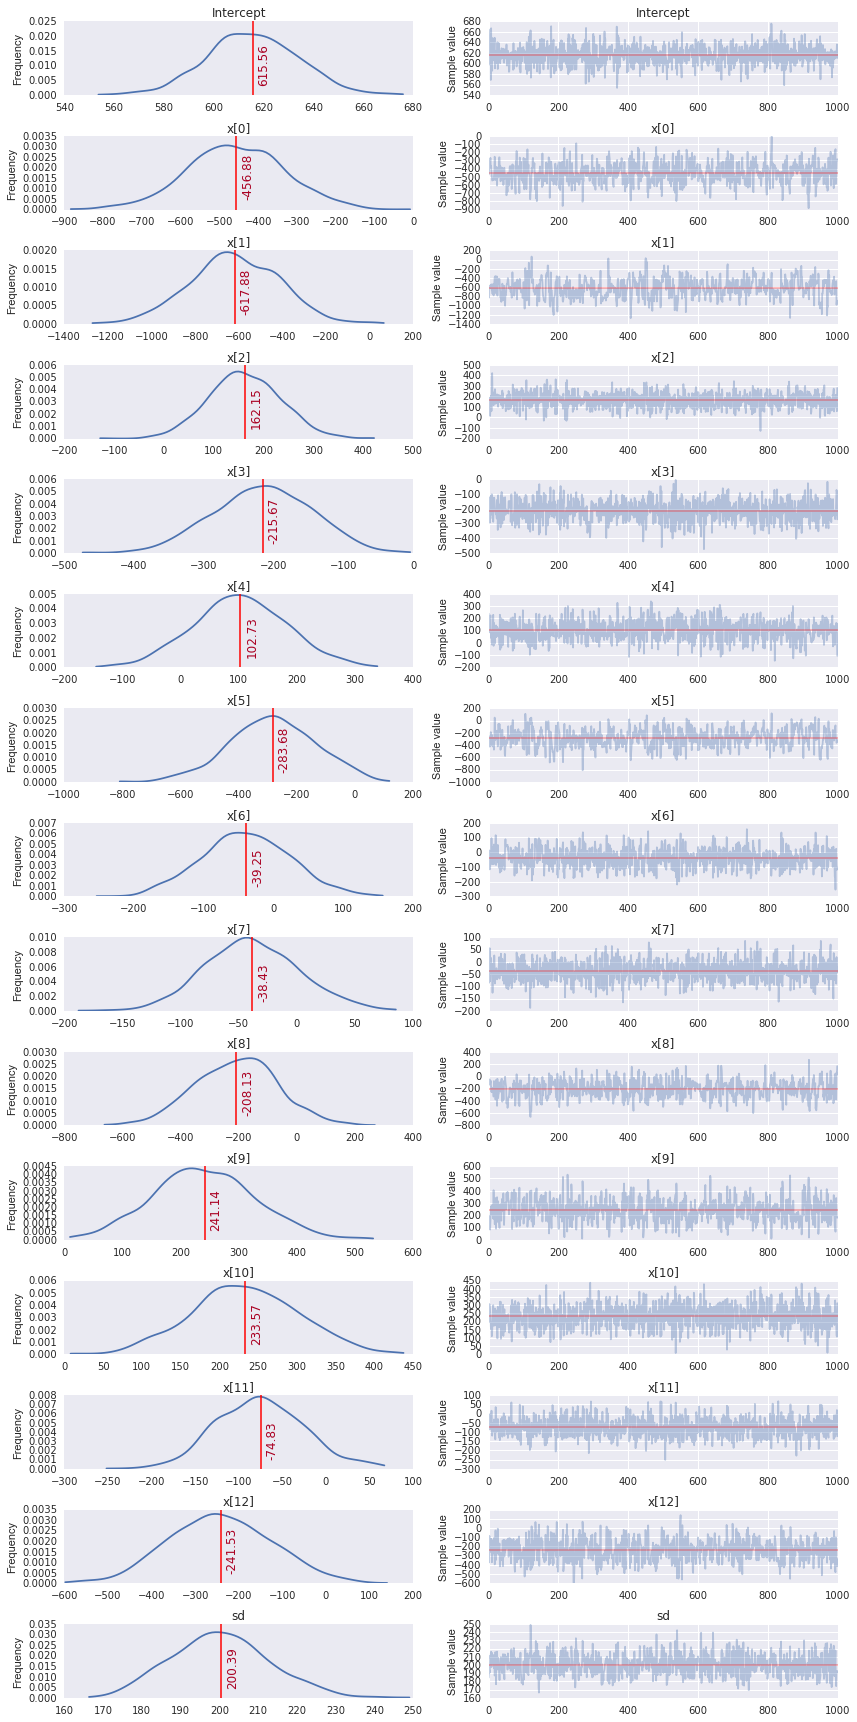

In [488]:
plot_traces(trc_pooled, retain=1000)


In [153]:
pm.df_summary(trc_pooled[-1000:])


,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,615.618778,18.432346,0.526172,577.652745,650.906236
x[0],-454.499622,124.282755,5.653387,-697.365561,-238.388170
x[1],-627.384075,216.315966,11.696789,-1040.214914,-192.514018
x[2],163.339784,68.545225,2.123644,32.074642,288.846695
x[3],-212.671487,69.665640,2.693435,-353.526349,-80.191205
x[4],97.552134,79.809225,2.769520,-42.754793,265.542409
x[5],-290.420769,151.559357,7.861018,-574.749359,-1.323005
x[6],-36.468039,63.533855,2.623794,-152.163206,89.839730
x[7],-38.872030,42.423852,1.422024,-113.402204,48.410221
x[8],-204.307121,133.954795,6.599343,-450.992716,68.287490


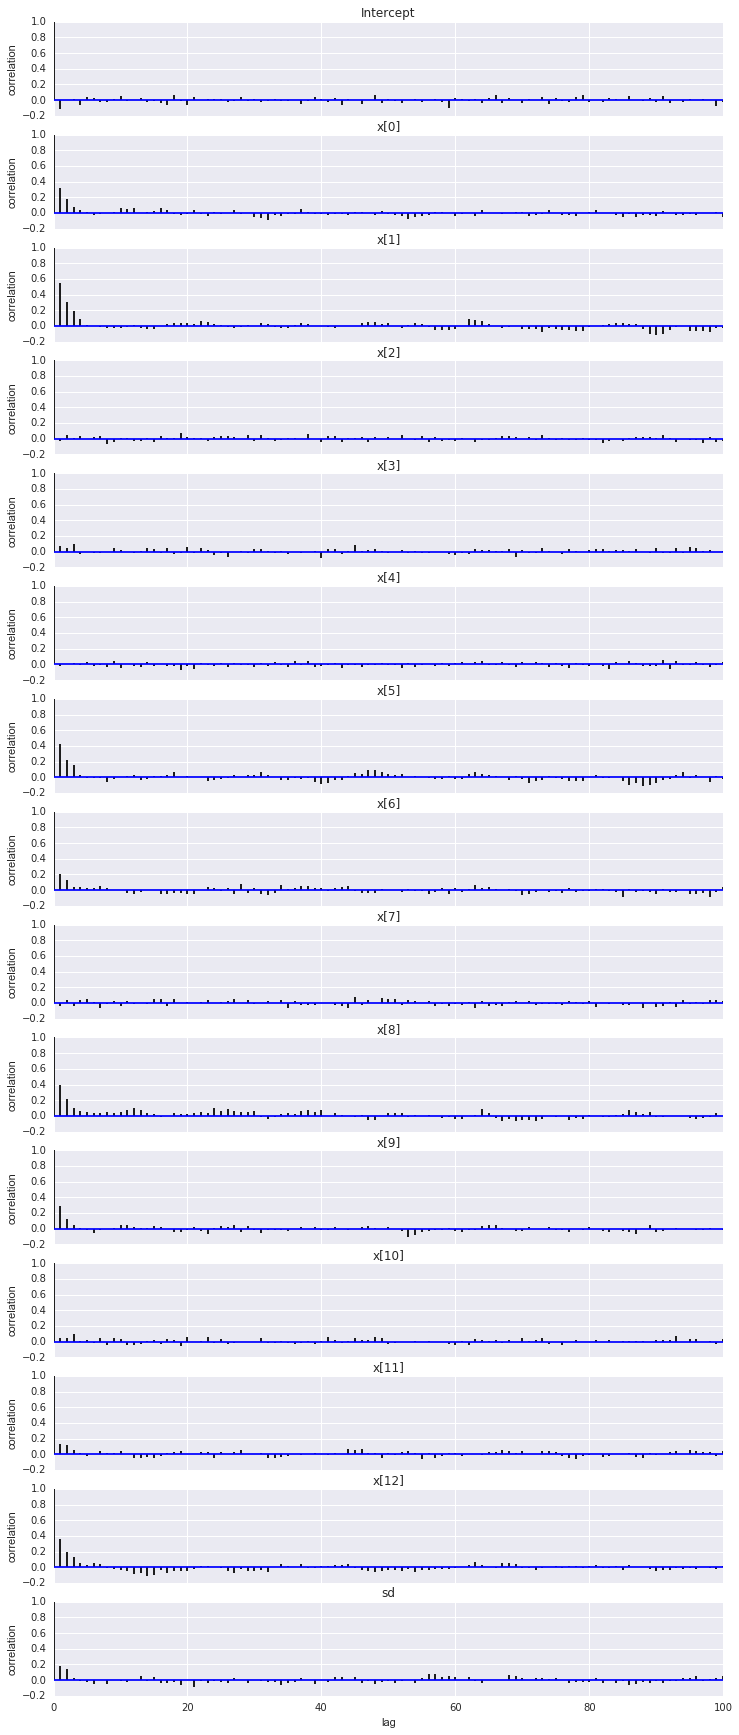

In [154]:
ax = pm.autocorrplot(trc_pooled[-1000:])


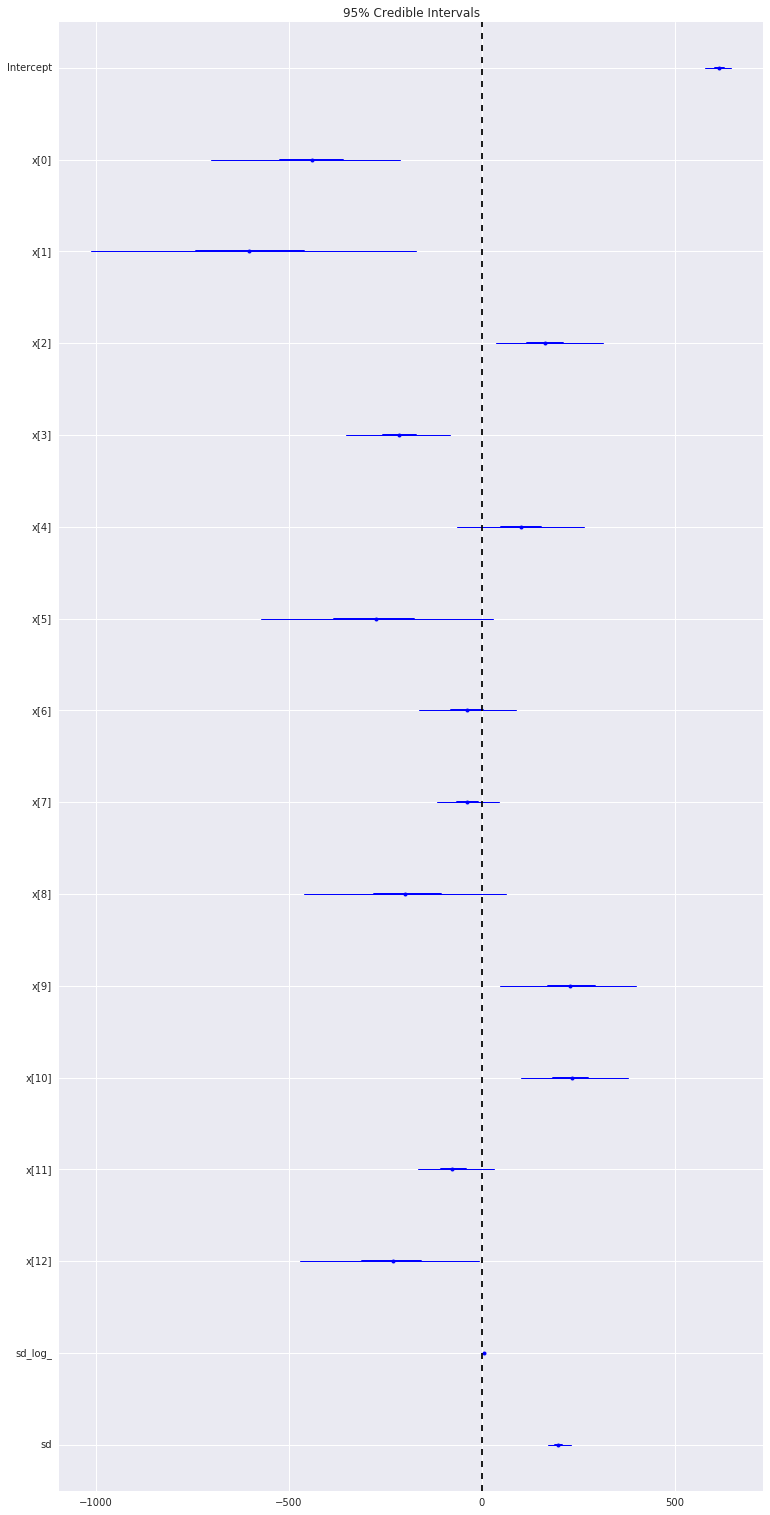

In [271]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_pooled)
# plt.savefig('../../Downloads/forestplot.png', dpi=400)
# plt.xlim(-1000, 1000)


In [480]:
ppc_pooled = pm.sample_ppc(trc_pooled[-1000:], samples=500, model=mdl_pooled, size=50)
y_pred1 = ppc_pooled['y'].mean(0).mean(0).T
waic_pooled = pm.stats.waic(model=mdl_pooled, trace=trc_pooled[-1000:])
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred1)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred1))
print 'Train_WAIC: {0}'.format(waic_pooled)


Train_RMSE: 188.574459301
Train_R2: 0.506470915216
Train_WAIC: 1805.60628416


(0, 1200)

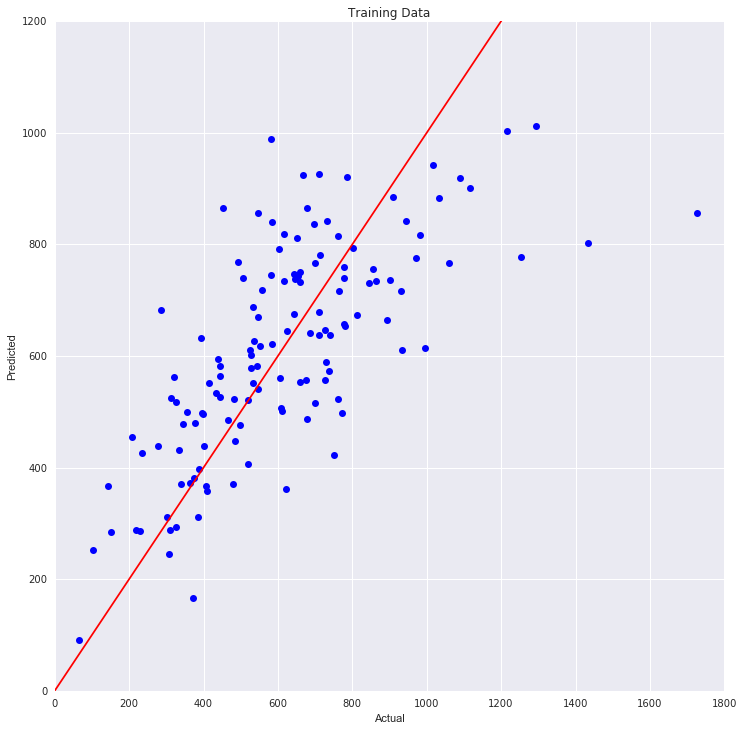

In [498]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_train, y_pred, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Training Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])



In [392]:
parm_pooled = pm.df_summary(trc_pooled[-1000:]).values

In [491]:
y_pred2 = parm_pooled[0,0] + np.dot(X_lasso_train_std.values, parm_pooled[1:-1,0])

(0, 1200)

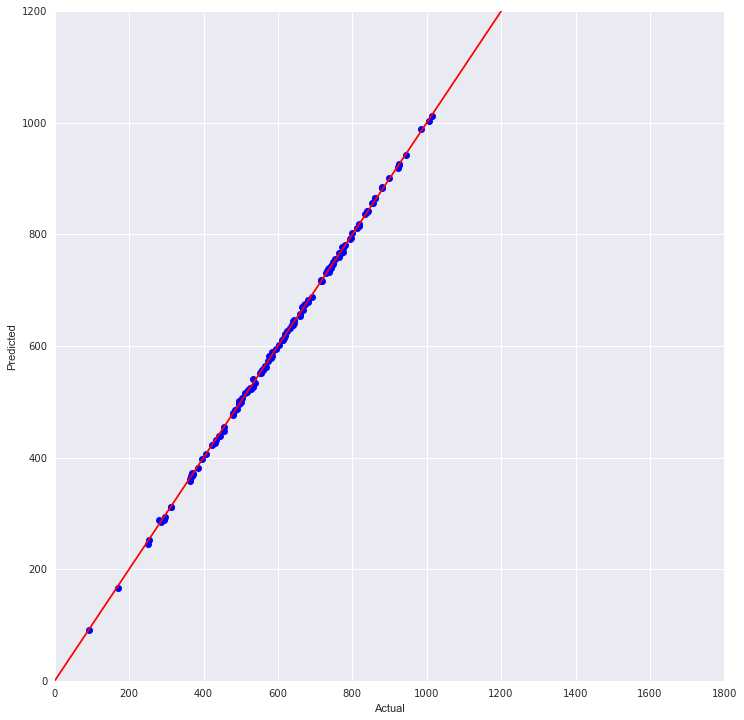

In [409]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_pred1, y_pred2, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [492]:
y_pred_test = parm_pooled[0,0] + np.dot(X_lasso_test_std.values, parm_pooled[1:-1,0])

In [495]:
print 'Test_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print 'Test_R2: {0}'.format(r2_score(y_test, y_pred_test))

Test_RMSE: 198.362616255
Test_R2: 0.190896405739


(0, 1200)

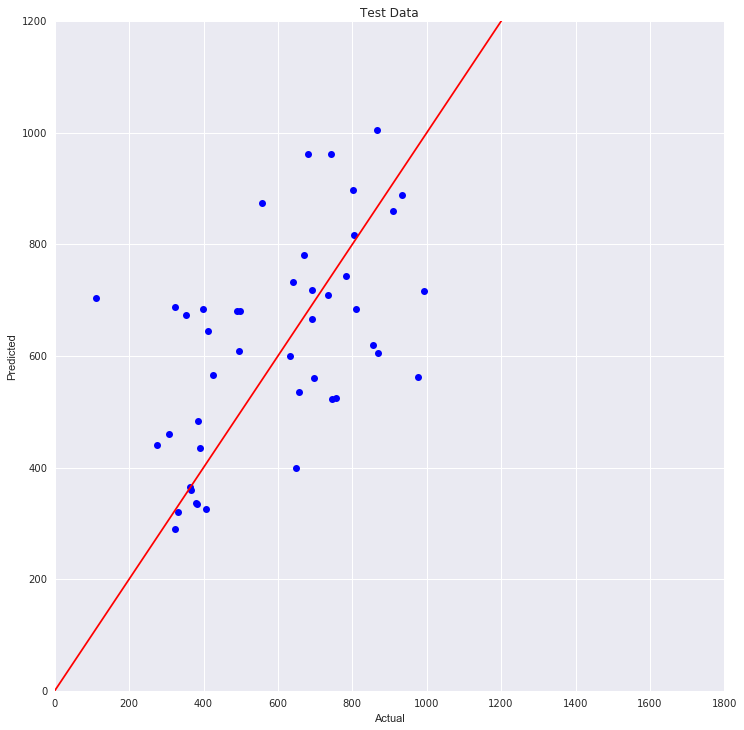

In [497]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_test, y_pred_test, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Test Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [285]:
x = pd.concat((X_lasso_train_std, X_train['XEC_FIELD_Code']), axis=1)
x.columns


Index([u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft',
       u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc',
       u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure',
       u'Fluid_Gal/Perf', u'XEC_FIELD_Code'],
      dtype='object')

In [343]:
with pm.Model() as mdl_unpooled:
   
    # define priors, use Normal
    b0 = pm.Normal('b0_XEC_FIELD_Code', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b1 = pm.Normal('b1_Clusters/Stage', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b2 = pm.Normal('b2_Perfs/Cluster', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b3 = pm.Normal('b3_#_of_Stages', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b4 = pm.Normal('b4_ISIP/Ft', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b5 = pm.Normal('b5_Rate/Ft', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b6 = pm.Normal('b6_Rate/Perf', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b7 = pm.Normal('b7_Avg_Prop_Conc', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b8 = pm.Normal('b8_Max_Prop_Conc', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b9 = pm.Normal('b9_Rate/Cluster', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b10 = pm.Normal('b10_Max_Rate', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b11 = pm.Normal('b11_Avg_Pressure', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b12 = pm.Normal('b12_Max_Pressure', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())    
    b13 = pm.Normal('b13_Fluid_Gal/Perf', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())    
    
    # define linear model
    y =    ( b0[x['XEC_FIELD_Code']] +
             b1[x['XEC_FIELD_Code']] * x['Clusters/Stage'] + 
             b2[x['XEC_FIELD_Code']] * x['Perfs/Cluster'] +
             b3[x['XEC_FIELD_Code']] * x['#_of_Stages'] +
             b4[x['XEC_FIELD_Code']] * x['ISIP/Ft'] +
             b5[x['XEC_FIELD_Code']] * x['Rate/Ft'] +
             b6[x['XEC_FIELD_Code']] * x['Rate/Perf'] +
             b7[x['XEC_FIELD_Code']] * x['Avg_Prop_Conc'] +
             b8[x['XEC_FIELD_Code']] * x['Max_Prop_Conc'] +
             b9[x['XEC_FIELD_Code']] * x['Rate/Cluster'] +
             b10[x['XEC_FIELD_Code']] * x['Max_Rate'] +
             b11[x['XEC_FIELD_Code']] * x['Avg_Pressure'] +
             b12[x['XEC_FIELD_Code']] * x['Max_Pressure'] +
             b13[x['XEC_FIELD_Code']] * x['Fluid_Gal/Perf'])

    ## Likelihood (sampling distribution) of observations
    epsilon = pm.HalfCauchy('epsilon', beta=10)
    likelihood = pm.Normal('likelihood', mu=y, sd=epsilon, observed=y_train)
 
    step = pm.NUTS()
    trc_unpooled = pm.sample(2000, step, progressbar=True)


Applied log-transform to epsilon and added transformed epsilon_log_ to model.
INFO:pymc3:Applied log-transform to epsilon and added transformed epsilon_log_ to model.
100%|██████████| 2000/2000 [04:11<00:00,  6.59it/s]


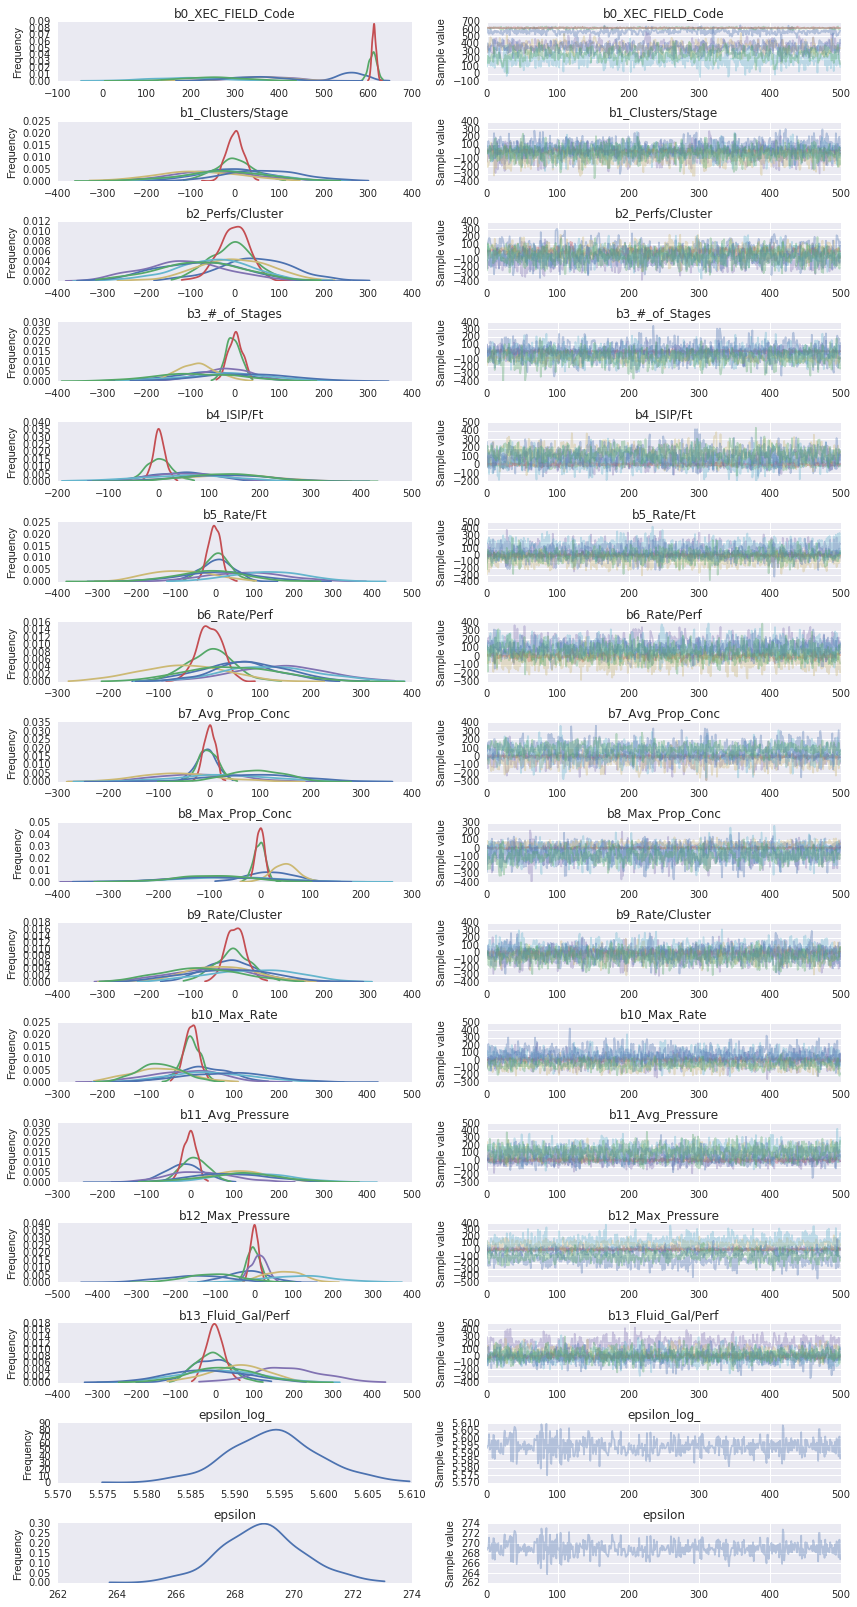

In [344]:
rvs_unpooled = [rv.name for rv in mdl_unpooled.unobserved_RVs]
ax = pm.traceplot(trc_unpooled[-500:], varnames=rvs_unpooled, figsize=(12,len(rvs_unpooled)*1.4), combined=False)


In [389]:
pm.df_summary(trc_unpooled[-500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_XEC_FIELD_Code__0,565.522094,29.409444,1.508210,514.883749,622.874836
b0_XEC_FIELD_Code__1,611.922482,8.831748,0.377186,592.993919,627.406732
b0_XEC_FIELD_Code__2,614.896718,4.654311,0.177726,606.198873,623.786038
b0_XEC_FIELD_Code__3,367.968052,63.489154,3.892546,233.734225,478.682118
b0_XEC_FIELD_Code__4,352.872704,64.621537,4.041757,218.637463,461.965459
b0_XEC_FIELD_Code__5,189.467391,84.773982,2.581728,25.275685,358.047145
b0_XEC_FIELD_Code__6,343.714284,62.577629,2.555541,220.879918,450.003424
b0_XEC_FIELD_Code__7,251.356437,70.381970,4.149298,113.299623,377.324696
b1_Clusters/Stage__0,-4.554496,77.657034,3.978947,-157.959330,147.083562
b1_Clusters/Stage__1,-2.246146,42.529492,1.729106,-88.412659,80.526214


(-1000, 1000)

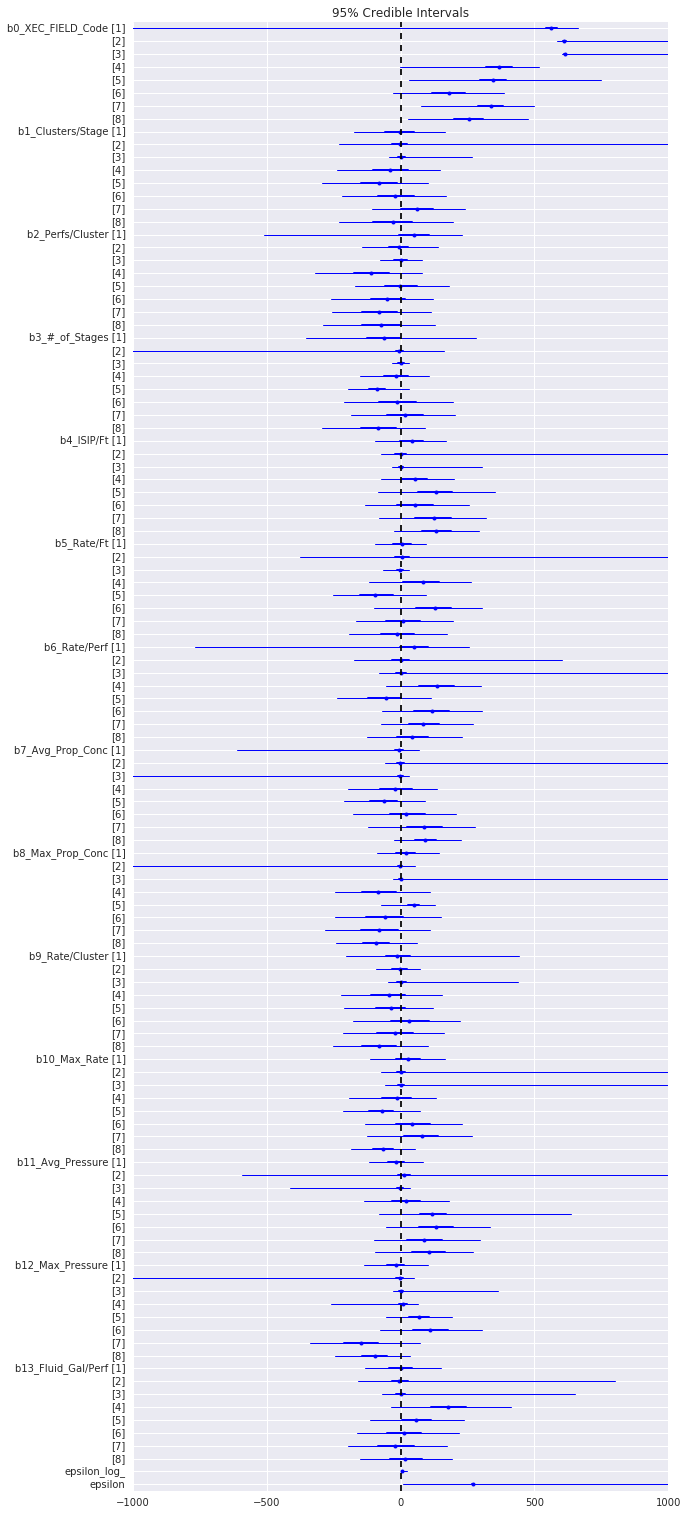

In [359]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_unpooled)
plt.xlim([-1000, 1000])



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


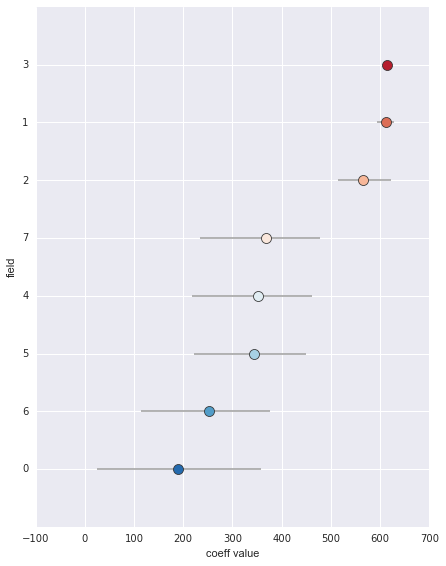

In [352]:
dfsm_unpl_field = create_smry(trc_unpooled[-500:], X_train, 'XEC_FIELD_Code')
custom_forestplot(dfsm_unpl_field)


In [293]:
X_train.groupby(['XEC_FIELD_Code'])['XEC_FIELD_Code'].count()


XEC_FIELD_Code
0    12
1    33
2    66
3     7
4     7
5     1
6     2
7     5
Name: XEC_FIELD_Code, dtype: int64

In [462]:
ppc_unpooled = pm.sample_ppc(trc_unpooled[-500:], samples=500, model=mdl_unpooled, size=50)
rmse_unpooled = compute_rmse(x, ppc_unpooled, y_train, 'likelihood')
r2_unpooled = compute_r2(x, ppc_unpooled, y_train, 'likelihood')
print 'Train_RMSE: {0}'.format(rmse_unpooled)
print 'Train_R2: {0}'.format(r2_unpooled)


Train_RMSE: 268.651234543
Train_R2: -0.00167005502964


In [384]:
ppc_pooled['y'].shape, ppc_unpooled['likelihood'].shape

((500, 50, 1, 133), (500, 50, 133))

In [374]:
pm.stats.waic(model=mdl_unpooled, trace=trc_unpooled[-500:])


248170.98145327743

(0, 1200)

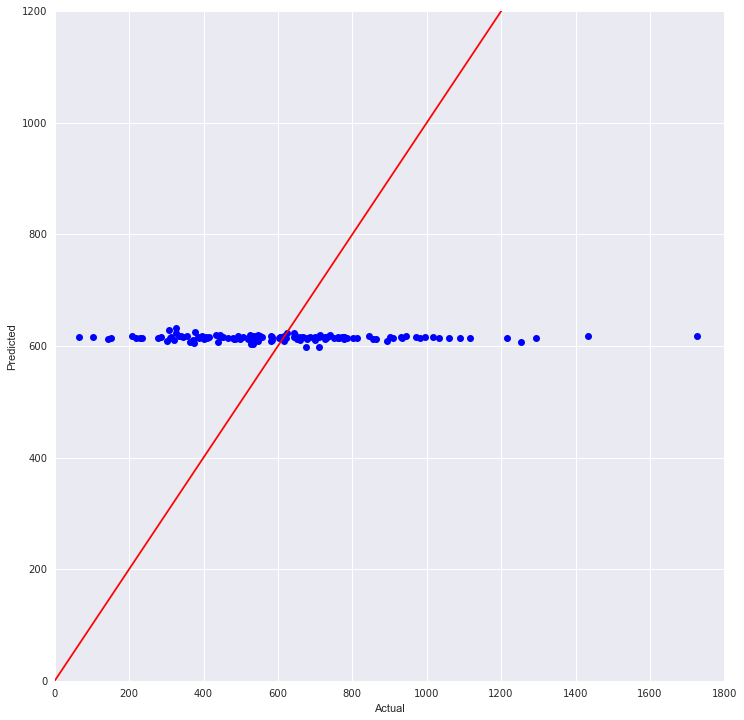

In [385]:
y_pred = ppc_unpooled['likelihood'].mean(0).mean(0).T
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_train, y_pred, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [412]:
parm_unpooled = pm.df_summary(trc_unpooled[-500:]).values

In [413]:
x_field = x[x['XEC_FIELD_Code'] == 0].drop(['XEC_FIELD_Code'], axis=1)
y_pred_unpooled = np.sum(parm_unpooled[0:8,0] + np.dot(x_field, parm_unpooled[8:-1,0].reshape(13,8)))

(113, 5)

In [434]:
x[x['XEC_FIELD_Code'] == 0].drop(['XEC_FIELD_Code'], axis=1).values.shape

(12, 13)

In [477]:
def y_pred_pooled(x, parm_unpooled, code_dict):
    y_pred_collect = []
    for code in x['XEC_FIELD_Code'].unique():
        x_field = x[x['XEC_FIELD_Code'] == code].drop(['XEC_FIELD_Code'], axis=1)
        y_pred = parm_unpooled[code,0] + np.dot(x_field, parm_unpooled[8:-1,0].reshape(13,8)
                                                                [:,code])
        y_pred_collect.append(y_pred)
    return y_pred_collect


In [478]:
y_pred_pooled(x, parm_unpooled, code_dict)


[array([ 615.27872169,  616.73741209,  615.78913767,  615.09237433,
         616.26071067,  615.26159283,  615.39795804,  615.31551556,
         614.20049168,  614.97358613,  615.41816131,  615.1209873 ,
         615.87165354,  613.60750041,  614.92397526,  615.0637982 ,
         615.13612175,  616.5256873 ,  615.4678743 ,  615.2266674 ,
         616.50181711,  615.8634913 ,  616.18495419,  616.96845933,
         615.99804745,  614.76813072,  615.48275439,  613.94262249,
         615.57208564,  616.28852599,  616.07253866,  614.92604076,
         615.1276091 ,  615.23245916,  616.60333372,  615.31357842,
         615.44456436,  615.55217154,  614.65735701,  615.62924212,
         616.34715367,  615.2106077 ,  615.39437048,  615.48003018,
         614.50544393,  616.26541324,  617.41515338,  616.75434381,
         616.30711496,  616.2757136 ,  615.36660841,  615.8242724 ,
         615.66309227,  615.51802281,  615.72326702,  616.45621382,
         615.37585613,  614.99722433,  615.36337

In [472]:
[len(arr) for arr in y_pred_pooled(x, parm_unpooled)]

[66, 33, 7, 5, 7, 12, 1, 2]